## Pipeline de um processo de Deep Learning implementado em PyTorch:

    1. Preparar os Dados
    2. Definir o Modelo
    3. Treinar o Modelo
    4. Avaliar o Modelo
    5. Usar o Modelo


## **MLP para classificação multiclasse**
**Dataset Iris (flores)**
- Dataset de imagens para previsão da espécie da flor dadas as medidas das flores
- 3 classes com 50 instâncias cada
- Classes: Iris Setosa, Iris Versicolour e Iris Virginica
- 5 atributos: 4 para dimensões numéricas e o 5º a classe da flor

## Imports

In [19]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.optim import SGD, Adam
from torch.nn import CrossEntropyLoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_

In [20]:
PATH = 'iris.csv'

device = torch.device("cpu")

EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.01

## 1. Preparar os Dados

In [21]:
class CSVDataset(Dataset):
    def __init__(self, path):
        df = pd.read_csv(path, header=None)
        self.X = df.values[:, :-1]
        self.y = df.values[:, -1]
        self.X = self.X.astype('float32')
        self.y = LabelEncoder().fit_transform(self.y)
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]
 
    def get_splits(self, n_test=0.33):
        test_size = round(n_test * len(self.X))
        train_size = len(self.X) - test_size
        return random_split(self, [train_size, test_size])
    
def prepare_data(path):
    dataset = CSVDataset(path)
    train, test = dataset.get_splits()
    train_dl = DataLoader(train, batch_size=32, shuffle=True)
    test_dl = DataLoader(test, batch_size=1024, shuffle=False)
    train_dl_all = DataLoader(train, batch_size=len(train), shuffle=False)
    test_dl_all = DataLoader(test, batch_size=len(test), shuffle=False)
    return train_dl, test_dl, train_dl_all, test_dl_all

train_dl, test_dl,  train_dl_all, test_dl_all = prepare_data(PATH)

## 1.1 Visualizar os Dados

In [22]:
from IPython.display import display

def visualize_data(path):
    df = pd.read_csv(path, header=None)
    display(df)

def visualize_dataset(train_dl, test_dl):
    print(f"Quantidade de casos de Treino:{len(train_dl.dataset)}") 
    print(f"Quantidade de casos de Teste:{len(test_dl.dataset)}")
    x, y = next(iter(train_dl))
    print(f"Shape tensor batch casos treino, input: {x.shape}, output: {y.shape}")
    x, y = next(iter(test_dl))  
    print(f"Shape tensor batch casos test, input: {x.shape}, output: {y.shape}")
    print(y)

visualize_data(PATH)
visualize_dataset(train_dl, test_dl)

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


Quantidade de casos de Treino:100
Quantidade de casos de Teste:50
Shape tensor batch casos treino, input: torch.Size([32, 4]), output: torch.Size([32])
Shape tensor batch casos test, input: torch.Size([50, 4]), output: torch.Size([50])
tensor([1, 2, 0, 0, 1, 0, 1, 2, 1, 2, 2, 2, 1, 0, 2, 2, 1, 0, 2, 0, 1, 1, 0, 2,
        1, 1, 2, 2, 0, 1, 2, 0, 2, 2, 1, 1, 2, 0, 2, 1, 2, 0, 2, 1, 0, 1, 0, 0,
        0, 0])


## 1.2 Verificar balanceamento do dataset

casos_treino: 100
Iris-setosa_Train:  34
Iris-versicolor_Train:  34
Iris-virginica_Train:  32
casos_test: 50
Iris-setosa_Test:  16
Iris-versicolor_Test:  16
Iris-virginica_Test:  18


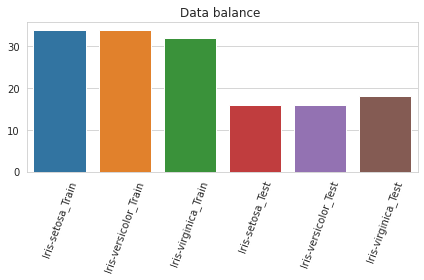

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_holdout_balance(y_train, y_test):
    _, y_train = next(iter(train_dl_all))
    _, y_test = next(iter(test_dl_all))

    sns.set_style('whitegrid')
    casos_treino=len(y_train) 
    casos_test=len(y_test)
    
    Iris_setosa_Train=np.count_nonzero(y_train == 0)
    Iris_versicolor_Train = np.count_nonzero(y_train == 1)
    Iris_virginica_Train = np.count_nonzero(y_train == 2)
    Iris_setosa_Test=np.count_nonzero(y_test == 0)
    Iris_versicolor_Test = np.count_nonzero(y_test == 1)
    Iris_virginica_Test = np.count_nonzero(y_test == 2)
    
    print("casos_treino:",casos_treino)
    print("Iris-setosa_Train: ", Iris_setosa_Train)
    print("Iris-versicolor_Train: ", Iris_versicolor_Train) 
    print("Iris-virginica_Train: ", Iris_virginica_Train)
    
    print("casos_test:",casos_test)
    print("Iris-setosa_Test: ", Iris_setosa_Test)
    print("Iris-versicolor_Test: ", Iris_versicolor_Test)
    print("Iris-virginica_Test: ", Iris_virginica_Test)

    grafico=sns.barplot(x=['Iris-setosa_Train','Iris-versicolor_Train', 'Iris-virginica_Train', 'Iris-setosa_Test', 'Iris-versicolor_Test', 'Iris-virginica_Test'], 
                        y=[Iris_setosa_Train, Iris_versicolor_Train, Iris_virginica_Train, Iris_setosa_Test, Iris_versicolor_Test, Iris_virginica_Test])
    grafico.set_title('Data balance ')
    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.show() 
    
visualize_holdout_balance(train_dl_all, test_dl_all)

## 2. Definir o Modelo

In [24]:
from torchinfo import summary

class MLP(Module):
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        self.hidden1 = Linear(n_inputs, 10)
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        self.hidden2 = Linear(10, 8)
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()
        self.hidden3 = Linear(8,3)
        xavier_uniform_(self.hidden3.weight)
        self.act3 = Softmax()
 
    def forward(self, X):
        X = self.hidden1(X)
        X = self.act1(X)
        X = self.hidden2(X)
        X = self.act2(X)
        X = self.hidden3(X)
        X = self.act3(X)
        return X

model = MLP(4)
print(summary(model, input_size=(BATCH_SIZE, 4), verbose=0))
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      --                        --
├─Linear: 1-1                            [32, 10]                  50
├─ReLU: 1-2                              [32, 10]                  --
├─Linear: 1-3                            [32, 8]                   88
├─ReLU: 1-4                              [32, 8]                   --
├─Linear: 1-5                            [32, 3]                   27
├─Softmax: 1-6                           [32, 3]                   --
Total params: 165
Trainable params: 165
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.01


/tmp/ipykernel_25162/935373995.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = self.act3(X)


MLP(
  (hidden1): Linear(in_features=4, out_features=10, bias=True)
  (act1): ReLU()
  (hidden2): Linear(in_features=10, out_features=8, bias=True)
  (act2): ReLU()
  (hidden3): Linear(in_features=8, out_features=3, bias=True)
  (act3): Softmax(dim=None)
)

## 3. Treinar o Modelo

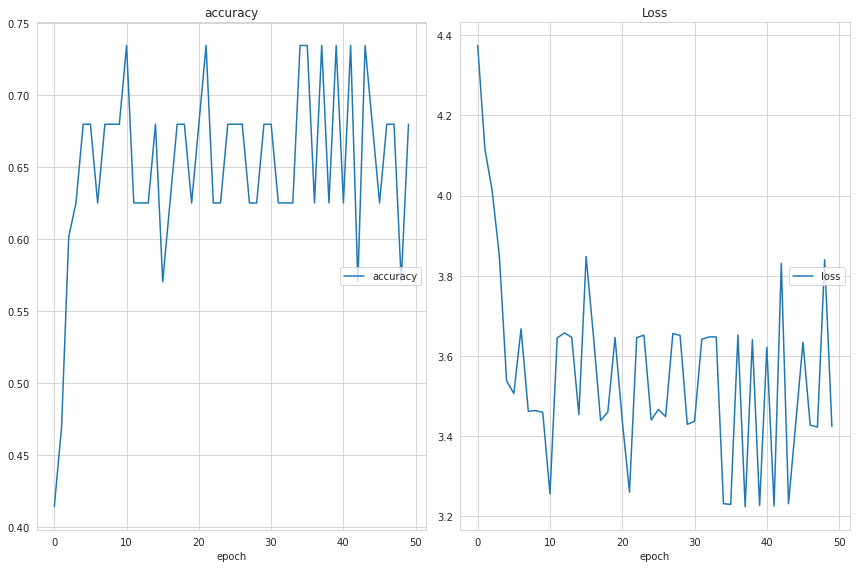

accuracy
	accuracy         	 (min:    0.414, max:    0.734, cur:    0.680)
Loss
	loss             	 (min:    3.224, max:    4.374, cur:    3.424)


In [25]:
from livelossplot import PlotLosses

def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

def train_model(train_dl, model):
    liveloss = PlotLosses()
    criterion = CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
    for epoch in range(EPOCHS):
        logs = {}
        epoch_loss  = 0
        epoch_acc  = 0
        for i, (inputs, labels) in enumerate(train_dl):
            optimizer.zero_grad()
            yprev = model(inputs)
            loss = criterion(yprev, labels)
            acc = accuracy_score(labels.numpy(), np.argmax(yprev.detach().numpy(), axis=1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
        print(f'Epoch {epoch:03}: | Loss: {epoch_loss/len(train_dl):.5f} | Acc: {epoch_acc/len(train_dl):.3f}')      
        logs['loss'] = epoch_loss
        logs['accuracy'] = epoch_acc/len(train_dl)
        liveloss.update(logs)
        liveloss.send()

train_model(train_dl, model)

## 4. Avaliar o Modelo

In [26]:
def evaluate_model(test_dl, model):
    predictions = list()
    actual_values = list()
    for i, (inputs, labels) in enumerate(test_dl):
        yprev = model(inputs)
        yprev = yprev.detach().numpy()
        actual = labels.numpy()
        yprev = np.argmax(yprev, axis=1)
        actual = actual.reshape((len(actual), 1))
        yprev = yprev.reshape((len(yprev), 1))
        predictions.append(yprev)
        actual_values.append(actual)
        break
    predictions, actual_values = np.vstack(predictions), np.vstack(actual_values)
    return predictions, actual_values
 
def display_confusion_matrix(cm):
    plt.figure(figsize = (16,8))
    sns.heatmap(cm,annot=True,xticklabels=['Iris-setosa','Iris-versicolor','Iris-virginica'],yticklabels=['Iris-setosa','Iris-versicolor','Iris-virginica'], annot_kws={"size": 12}, fmt='g', linewidths=.5)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show() 
    
predictions, actual_values = evaluate_model(test_dl, model)

acertou=0
falhou = 0
for r,p in zip(actual_values, predictions):
    print(f'real:{r} previsão:{p}') 
    if r==p: acertou+=1  
    else: falhou+=1

acc = accuracy_score(actual_values, predictions)
print(f'Accuracy: {acc:0.3f}\n')
print(f'acertou:{acertou} falhou:{falhou}')

print(classification_report(actual_values, predictions))
cm = confusion_matrix(actual_values, predictions)


real:[1] previsão:[2]
real:[2] previsão:[2]
real:[0] previsão:[0]
real:[0] previsão:[0]
real:[1] previsão:[2]
real:[0] previsão:[0]
real:[1] previsão:[2]
real:[2] previsão:[2]
real:[1] previsão:[2]
real:[2] previsão:[2]
real:[2] previsão:[2]
real:[2] previsão:[2]
real:[1] previsão:[2]
real:[0] previsão:[0]
real:[2] previsão:[2]
real:[2] previsão:[2]
real:[1] previsão:[2]
real:[0] previsão:[0]
real:[2] previsão:[2]
real:[0] previsão:[0]
real:[1] previsão:[2]
real:[1] previsão:[0]
real:[0] previsão:[0]
real:[2] previsão:[2]
real:[1] previsão:[0]
real:[1] previsão:[2]
real:[2] previsão:[2]
real:[2] previsão:[2]
real:[0] previsão:[0]
real:[1] previsão:[0]
real:[2] previsão:[2]
real:[0] previsão:[0]
real:[2] previsão:[2]
real:[2] previsão:[2]
real:[1] previsão:[2]
real:[1] previsão:[0]
real:[2] previsão:[2]
real:[0] previsão:[0]
real:[2] previsão:[2]
real:[1] previsão:[2]
real:[2] previsão:[2]
real:[0] previsão:[0]
real:[2] previsão:[2]
real:[1] previsão:[2]
real:[0] previsão:[0]
real:[1] p

/tmp/ipykernel_25162/935373995.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = self.act3(X)
/home/risingfisan/miniconda3/envs/AP/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/risingfisan/miniconda3/envs/AP/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/risingfisan/miniconda3/envs/AP/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-sc

## 5. Usar o Modelo

In [27]:
def predict(row, model):
    row = Tensor([row])
    yprev = model(row)
    yprev = yprev.detach().numpy()
    return yprev

row = [5.1, 3.5, 1.4, 0.2]
yprev = predict(row, model)
print('Predicted: %s (class=%d)' % (yprev, np.argmax(yprev)))

Predicted: [[9.9996567e-01 2.6811003e-07 3.4128247e-05]] (class=0)


/tmp/ipykernel_25162/935373995.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = self.act3(X)
